# FIREX vertical profile figure

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import xarray as xr
from pyproj import Proj
import matplotlib.pyplot as plt

In [3]:
# get rid of copy on write warning
# see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
pd.options.mode.copy_on_write = True

In [4]:
workdir = './'
data_dir = f'{workdir}/data'

## get paired FIREX CMAQ data

In [5]:
firexdir = f'{data_dir}/firex'

# CRACMM1
simlabel1 = '20240104_cracmm1_annual_v2' # simulation label
datelabel1 = '20240129'                  # date pairing script was run for this case
simname1 = 'CRACMM1'                     # for plot labeling
firexfn1 = f'extract_{datelabel1}_firexaq_cmaq_paired_byminute_{simlabel1}'
firexdf1 = pd.read_csv(f'{firexdir}/{firexfn1}.csv', index_col=0)

# CRACMM2
simlabel2 = '20240105_cracmm2_annual_fix_ptnonipm_sty'
datelabel2 = '20240129'
simname2 = 'CRACMM2'
firexfn2 = f'extract_{datelabel2}_firexaq_cmaq_paired_byminute_{simlabel2}'
firexdf2 = pd.read_csv(f'{firexdir}/{firexfn2}.csv', index_col=0)

### select data with valid ISAF and CAMS obs

In [6]:
isaf_k = 'CH2O_ISAF_HANISCO_pptv'
cams_k = 'CH2O_CAMS_pptv_FRIED_pptv'

firexdf1 = firexdf1.dropna(subset=[isaf_k, cams_k])
assert len(firexdf1[firexdf1[isaf_k].isna()]) == 0 # double check
assert len(firexdf1[firexdf1[cams_k].isna()]) == 0

firexdf2 = firexdf2.dropna(subset=[isaf_k, cams_k])
assert len(firexdf2[firexdf2[isaf_k].isna()]) == 0 # double check
assert len(firexdf2[firexdf2[cams_k].isna()]) == 0

### separate into smoke and background

In [7]:
# smoke flag is 1 when in plume NaN otherwise
firexdf1_smoke = firexdf1.query('Smoke_flag_SCHWARZ_none==1')
firexdf1_bkgrd = firexdf1.query('Smoke_flag_SCHWARZ_none!=1')

firexdf2_smoke = firexdf2.query('Smoke_flag_SCHWARZ_none==1')
firexdf2_bkgrd = firexdf2.query('Smoke_flag_SCHWARZ_none!=1')

### bin by altidue

200 m bins below 3 km; 500 bins above 3 km

In [8]:
alt_bins = np.hstack(
    (np.arange(0., 3001., 200.),
    np.arange(3500., 12001., 500.))
)

alt_labels = [(alt_bins[i-1]+alt_bins[i])/2. for i in range(1, len(alt_bins))]

firexdf1_bkgrd['alt_bins_m'] = pd.cut(
    firexdf1_bkgrd['Radar_Altitude_m'],
    alt_bins,
    labels=alt_labels
)
firexdf2_bkgrd['alt_bins_m'] = pd.cut(
    firexdf2_bkgrd['Radar_Altitude_m'],
    alt_bins,
    labels=alt_labels
)

### separate into western and eastern US

west vs. east based on -97 degrees longitude

In [9]:
obskeys = [isaf_k, cams_k]

firexdf1_bkgrd_west = firexdf1_bkgrd.query('Longitude_deg <= -97')
firexdf1_bkgrd_west_alt_group = firexdf1_bkgrd_west.dropna(subset=obskeys).groupby(by='alt_bins_m')
firexdf1_bkgrd_east = firexdf1_bkgrd.query('Longitude_deg > -97')
firexdf1_bkgrd_east_alt_group = firexdf1_bkgrd_east.dropna(subset=obskeys).groupby(by='alt_bins_m')

firexdf2_bkgrd_west = firexdf2_bkgrd.query('Longitude_deg < -97')
firexdf2_bkgrd_west_alt_group = firexdf2_bkgrd_west.dropna(subset=obskeys).groupby(by='alt_bins_m')
firexdf2_bkgrd_east = firexdf2_bkgrd.query('Longitude_deg > -97')
firexdf2_bkgrd_east_alt_group = firexdf2_bkgrd_east.dropna(subset=obskeys).groupby(by='alt_bins_m')

### separate California from rest of western US

In [10]:
state_mask = xr.open_dataset(f'{data_dir}/statemask/GRIDMASK_STATES_12US1.nc')
state_mask = state_mask.assign_coords({'ROW': state_mask.ROW, 'COL': state_mask.COL})
cal_mask = state_mask['CA'].squeeze()

projstr = "+proj=lcc +lat_0=40.0 +lon_0=-97.0 +lat_1=33.0 +lat_2=45.0 +x_0=2556000.0 +y_0=1728000.0 +R=6370000.0 +to_meter=12000.0 +no_defs +type=crs"
cmaqproj = Proj(projstr)
firexdf1_bkgrd_west['cmaqI'], firexdf1_bkgrd_west['cmaqJ'] = cmaqproj(firexdf1_bkgrd_west['Longitude_deg'].values, firexdf1_bkgrd_west['Latitude_deg'].values)

idx2D = {
    'ROW': xr.DataArray(firexdf1_bkgrd_west['cmaqJ'].values),
    'COL': xr.DataArray(firexdf1_bkgrd_west['cmaqI'].values)
}
cal_mask_at_firex = cal_mask.sel(**idx2D, method='nearest')
firexdf1_bkgrd_west['Cal_mask'] = cal_mask_at_firex.to_dataframe().set_index(firexdf1_bkgrd_west.index)['CA']
firexdf2_bkgrd_west['Cal_mask'] = cal_mask_at_firex.to_dataframe().set_index(firexdf2_bkgrd_west.index)['CA']

firexdf1_bkgrd_west_cal = firexdf1_bkgrd_west[firexdf1_bkgrd_west['Cal_mask']==1]
firexdf1_bkgrd_west_cal_alt_group = firexdf1_bkgrd_west_cal.dropna(subset=obskeys).groupby(by='alt_bins_m')
firexdf2_bkgrd_west_cal = firexdf2_bkgrd_west[firexdf2_bkgrd_west['Cal_mask']==1]
firexdf2_bkgrd_west_cal_alt_group = firexdf2_bkgrd_west_cal.dropna(subset=obskeys).groupby(by='alt_bins_m')

firexdf1_bkgrd_west_not_cal = firexdf1_bkgrd_west[firexdf1_bkgrd_west['Cal_mask']<1]
firexdf1_bkgrd_west_not_cal_alt_group = firexdf1_bkgrd_west_not_cal.dropna(subset=obskeys).groupby(by='alt_bins_m')
firexdf2_bkgrd_west_not_cal = firexdf2_bkgrd_west[firexdf2_bkgrd_west['Cal_mask']<1]
firexdf2_bkgrd_west_not_cal_alt_group = firexdf2_bkgrd_west_not_cal.dropna(subset=obskeys).groupby(by='alt_bins_m')

## vertical profile plot

In [11]:
plt.rcParams.update({'font.size': 10})

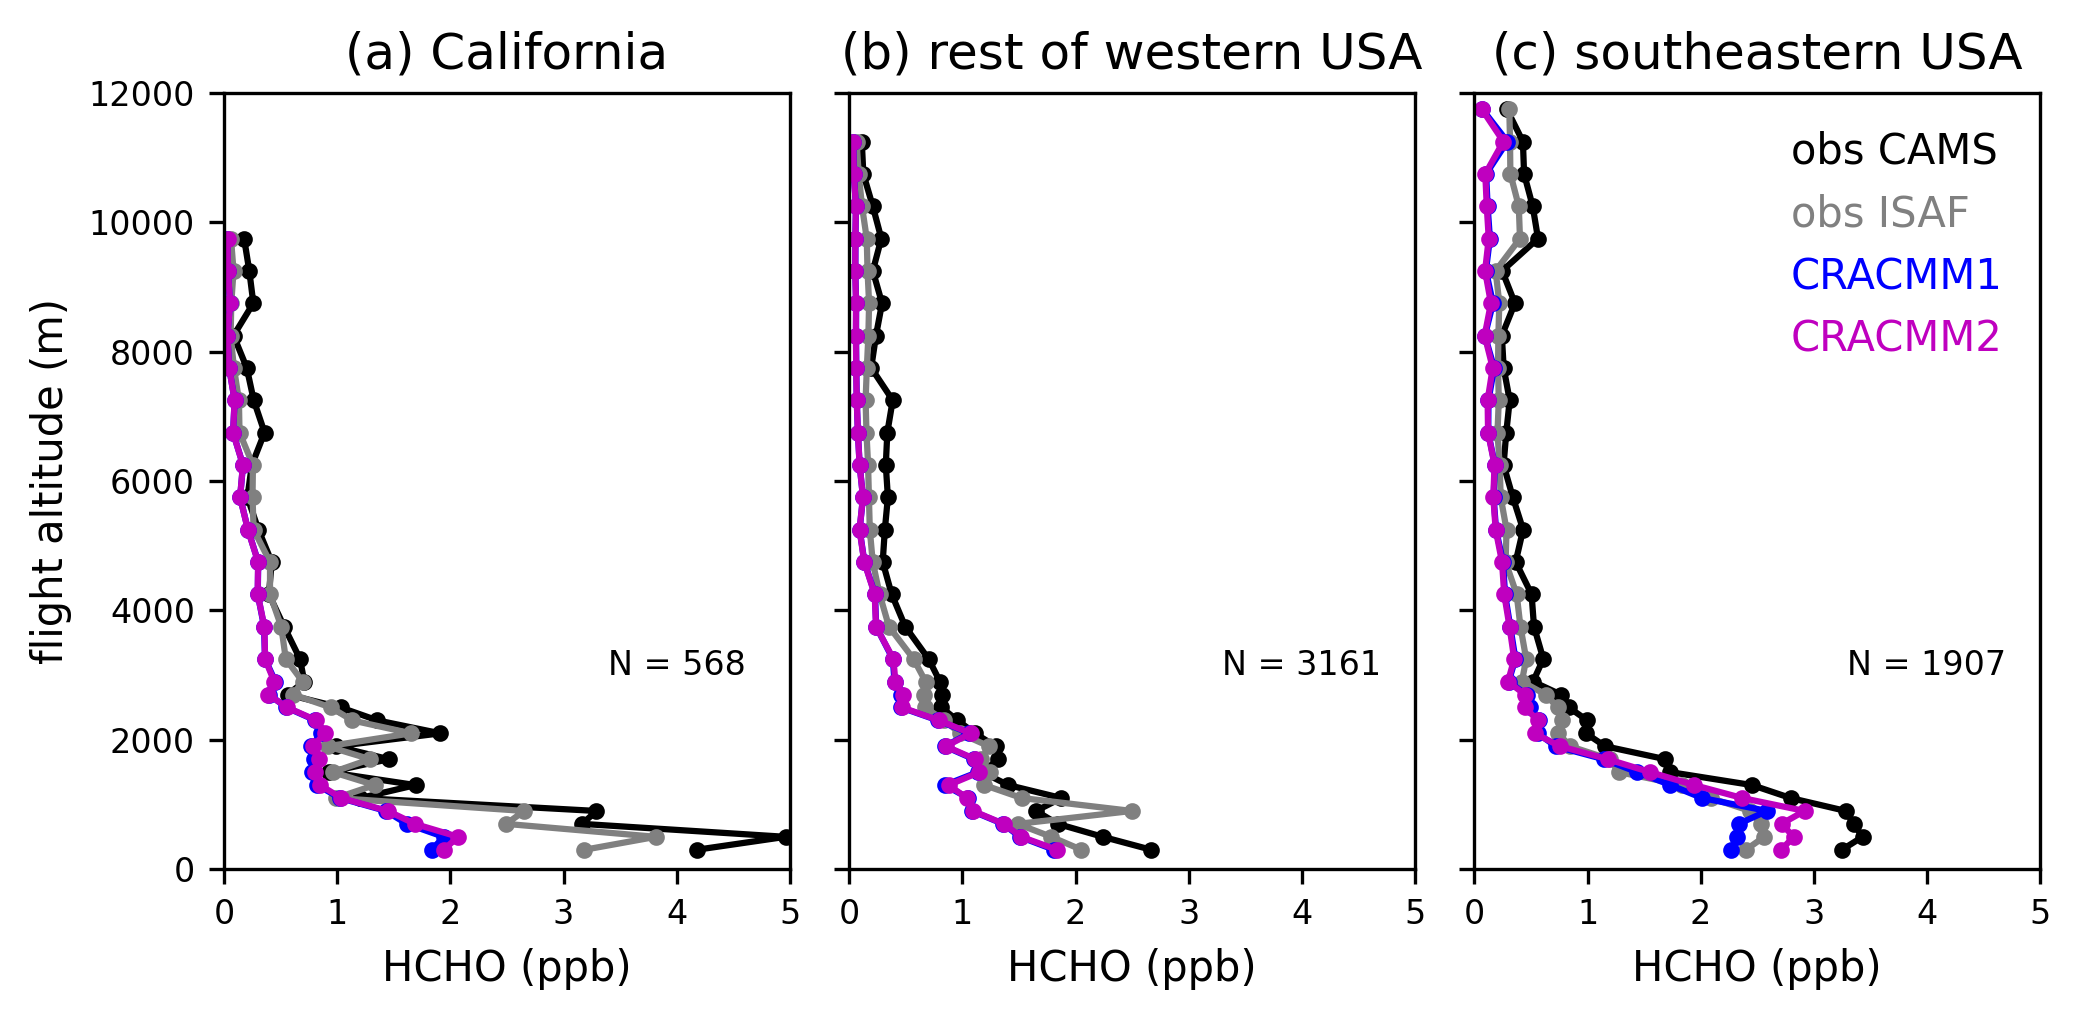

In [12]:
obsk1 = 'CH2O_CAMS_pptv_FRIED_pptv'
obslabel1 = 'obs CAMS'
obsk2 = 'CH2O_ISAF_HANISCO_pptv'
obslabel2 = 'obs ISAF'
modk = 'HCHO_mod_ppmv'
zk = 'Radar_Altitude_m'
markersize = 3

fig = plt.figure(figsize=(7, 3.5), dpi=300)
# california
ax1 = fig.add_subplot(131)
y =  firexdf1_bkgrd_west_cal_alt_group.mean().iloc[1:].index # midpoints of altitude bins
xobs1 = firexdf1_bkgrd_west_cal_alt_group.mean()[obsk1].iloc[1:]/1e3 # obs ppt to ppb
N_obs = len(firexdf1_bkgrd_west_cal)
xobs2 = firexdf1_bkgrd_west_cal_alt_group.mean()[obsk2].iloc[1:]/1e3
xmod1 = firexdf1_bkgrd_west_cal_alt_group.mean()[modk].iloc[1:]*1e3 # mod ppm to ppb
xmod2 = firexdf2_bkgrd_west_cal_alt_group.mean()[modk].iloc[1:]*1e3
ax1.plot(xobs1, y, '-ok', markersize=markersize)
ax1.plot(xobs2, y, '-o', color='grey', markersize=markersize)
ax1.plot(xmod1, y, '-ob', markersize=markersize)
ax1.plot(xmod2, y, '-om', markersize=markersize)
ax1.annotate(f'N = {N_obs}', xy=(4, 3000), xycoords='data', ha='center', fontsize=8)
ax1.tick_params(labelsize=8)
plt.xlabel('HCHO (ppb)')
plt.ylabel('flight altitude (m)')
plt.xlim([0, 5])
plt.ylim([0, 12000])
plt.title('(a) California')
# rest of western US
ax2 = fig.add_subplot(132)
y =  firexdf1_bkgrd_west_not_cal_alt_group.mean().iloc[1:].index # midpoints of altitude bins
xobs1 = firexdf1_bkgrd_west_not_cal_alt_group.mean()[obsk1].iloc[1:]/1e3 # obs ppt to ppb
N_obs = len(firexdf1_bkgrd_west_not_cal)
xobs2 = firexdf1_bkgrd_west_not_cal_alt_group.mean()[obsk2].iloc[1:]/1e3
xmod1 = firexdf1_bkgrd_west_not_cal_alt_group.mean()[modk].iloc[1:]*1e3 # mod ppm to ppb
xmod2 = firexdf2_bkgrd_west_not_cal_alt_group.mean()[modk].iloc[1:]*1e3
ax2.plot(xobs1, y, '-ok', markersize=markersize)
ax2.plot(xobs2, y, '-o', color='grey', markersize=markersize)
ax2.plot(xmod1, y, '-ob', markersize=markersize)
ax2.plot(xmod2, y, '-om', markersize=markersize)
ax2.annotate(f'N = {N_obs}', xy=(4, 3000), xycoords='data', ha='center', fontsize=8)
ax2.tick_params(labelleft=False, labelsize=8)
plt.xlabel('HCHO (ppb)')
plt.xlim([0, 5])
plt.ylim([0, 12000])
plt.title('(b) rest of western USA')
# eastern US
ax3 = fig.add_subplot(133)
y =  firexdf1_bkgrd_east_alt_group.mean().iloc[1:].index # midpoints of altitude bins
xobs1 = firexdf1_bkgrd_east_alt_group.mean()[obsk1].iloc[1:]/1e3 # obs ppt to ppb
N_obs = len(firexdf1_bkgrd_east)
xobs2 = firexdf1_bkgrd_east_alt_group.mean()[obsk2].iloc[1:]/1e3
xmod1 = firexdf1_bkgrd_east_alt_group.mean()[modk].iloc[1:]*1e3 # mod ppm to ppb
xmod2 = firexdf2_bkgrd_east_alt_group.mean()[modk].iloc[1:]*1e3
ax3.plot(xobs1, y, '-ok', markersize=markersize)
ax3.plot(xobs2, y, '-o', color='grey', markersize=markersize)
ax3.plot(xmod1, y, '-ob', markersize=markersize)
ax3.plot(xmod2, y, '-om', markersize=markersize)
ax3.annotate(f'N = {N_obs}', xy=(4, 3000), xycoords='data', ha='center', fontsize=8)
ax3.tick_params(labelleft=False, labelsize=8)
plt.xlabel('HCHO (ppb)')
plt.xlim([0, 5])
plt.ylim([0, 12000])
plt.title('(c) southeastern USA')

# dummy lines for legend
colors = ('k', 'grey', 'b', 'm')
labels = (obslabel1, obslabel2, simname1, simname2)
for color, label in zip(colors, labels):
    plt.plot([], color=color, label=label)
plt.legend(
    labelcolor='linecolor',
    handlelength=0,
    handletextpad=0,
    frameon=False
)

plt.tight_layout()
fig.savefig('figures/fig05.tiff')